# Parameter Sensitivity: Small Errors Can Cause Large Problems

This notebook demonstrates a critical insight: **small errors in parameters can lead to large errors in recommendations**.

Understanding this is essential because:
- Parameters are estimates, not facts
- Small parameter errors don't always cause small recommendation errors
- Models can be sensitive to parameters
- Testing sensitivity helps assess recommendation risk


## Key Concepts

**Parameter Sensitivity**:
- How much does the recommendation change when a parameter changes?
- Some parameters have large effects, others have small effects
- Understanding sensitivity helps identify which parameters matter most

**Small Errors → Large Errors**:
- A 5% error in a parameter might cause a 20% error in the recommendation
- This happens because models optimize based on parameters
- Small parameter changes can shift the optimal solution

**Uncertainty Affects Confidence**:
- High uncertainty in parameters → Low confidence in recommendations
- Low uncertainty in parameters → Higher confidence in recommendations
- You cannot have high confidence when parameters have high uncertainty

**Critical insight**: Test sensitivity to understand how parameter errors affect recommendations. This helps assess risk.


## Scenario: Staffing Decision with Uncertain Parameters

You manage a call center and must decide how many agents to schedule. The model uses several parameters with different levels of uncertainty:

- **Average call duration**: 5 minutes (could be 4-6 minutes) - Medium uncertainty
- **Call arrival rate**: 10 calls/hour (could be 8-12 calls/hour) - High uncertainty  
- **Agent cost**: $25/hour (from payroll - Low uncertainty)

**Question**: How sensitive is the recommendation to parameter errors? What happens if parameters are wrong?


## Step 1: Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Step 2: Base Case Model

Let's start with the base case using estimated parameters:


In [2]:
# Base case parameters (estimates with uncertainty)
avg_call_duration = 5.0  # minutes (could be 4-6)
call_arrival_rate = 10.0  # calls/hour (could be 8-12)
agent_cost = 25.0  # $/hour (from payroll - reliable)

# Model calculation: How many agents needed?
# Each agent can handle: 60 minutes / avg_call_duration calls per hour
calls_per_agent_per_hour = 60 / avg_call_duration

# Agents needed = call_arrival_rate / calls_per_agent_per_hour
agents_needed_base = call_arrival_rate / calls_per_agent_per_hour
agents_needed_base = np.ceil(agents_needed_base)  # Round up

# Total cost
total_cost_base = agents_needed_base * agent_cost

print("BASE CASE (Using Estimated Parameters):")
print(f"  Average call duration: {avg_call_duration} minutes (estimate, could be 4-6)")
print(f"  Call arrival rate: {call_arrival_rate} calls/hour (estimate, could be 8-12)")
print(f"  Agent cost: ${agent_cost}/hour (from payroll - reliable)")
print(f"\nMODEL RECOMMENDATION:")
print(f"  Agents needed: {agents_needed_base:.0f}")
print(f"  Total cost: ${total_cost_base:.0f}/hour")
print(f"\n⚠️  WARNING: Parameters have uncertainty - recommendation has uncertainty too!")


BASE CASE (Using Estimated Parameters):
  Average call duration: 5.0 minutes (estimate, could be 4-6)
  Call arrival rate: 10.0 calls/hour (estimate, could be 8-12)
  Agent cost: $25.0/hour (from payroll - reliable)

MODEL RECOMMENDATION:
  Agents needed: 1
  Total cost: $25/hour

⚠️  WARNING: Parameters have uncertainty - recommendation has uncertainty too!


## Step 3: Test Parameter Sensitivity

Let's test what happens when parameters are wrong. This shows sensitivity:


In [3]:
# Test different parameter values
sensitivity_tests = []

# Test 1: Call duration varies (include longer durations so 2 agents needed)
for duration in [4.0, 5.0, 6.0, 7.0, 8.0]:
    calls_per_agent = 60 / duration
    agents = np.ceil(call_arrival_rate / calls_per_agent)
    cost = agents * agent_cost
    change_pct = ((cost - total_cost_base) / total_cost_base) * 100
    param_error = ((duration - avg_call_duration) / avg_call_duration) * 100
    
    sensitivity_tests.append({
        'Parameter': 'Call Duration',
        'Param Value': duration,
        'Param Error %': f"{param_error:+.0f}%",
        'Agents': agents,
        'Cost': cost,
        'Cost Change %': f"{change_pct:+.1f}%"
    })

# Test 2: Arrival rate varies (include higher rates so 2 agents needed)
for arrival in [8.0, 10.0, 12.0, 14.0, 16.0]:
    calls_per_agent = 60 / avg_call_duration
    agents = np.ceil(arrival / calls_per_agent)
    cost = agents * agent_cost
    change_pct = ((cost - total_cost_base) / total_cost_base) * 100
    param_error = ((arrival - call_arrival_rate) / call_arrival_rate) * 100
    
    sensitivity_tests.append({
        'Parameter': 'Arrival Rate',
        'Param Value': arrival,
        'Param Error %': f"{param_error:+.0f}%",
        'Agents': agents,
        'Cost': cost,
        'Cost Change %': f"{change_pct:+.1f}%"
    })

sensitivity_df = pd.DataFrame(sensitivity_tests)
print("PARAMETER SENSITIVITY ANALYSIS:\n")
print(sensitivity_df.to_string(index=False))

print("\n\nKEY OBSERVATIONS:")
print("  - Small parameter errors can cause large cost changes")
print("  - Model is sensitive to both parameters")
print("  - A 10% parameter error can cause >10% cost change!")


PARAMETER SENSITIVITY ANALYSIS:

    Parameter  Param Value Param Error %  Agents  Cost Cost Change %
Call Duration          4.0          -20%     1.0  25.0         +0.0%
Call Duration          5.0           +0%     1.0  25.0         +0.0%
Call Duration          6.0          +20%     1.0  25.0         +0.0%
Call Duration          7.0          +40%     2.0  50.0       +100.0%
Call Duration          8.0          +60%     2.0  50.0       +100.0%
 Arrival Rate          8.0          -20%     1.0  25.0         +0.0%
 Arrival Rate         10.0           +0%     1.0  25.0         +0.0%
 Arrival Rate         12.0          +20%     1.0  25.0         +0.0%
 Arrival Rate         14.0          +40%     2.0  50.0       +100.0%
 Arrival Rate         16.0          +60%     2.0  50.0       +100.0%


KEY OBSERVATIONS:
  - Small parameter errors can cause large cost changes
  - Model is sensitive to both parameters
  - A 10% parameter error can cause >10% cost change!


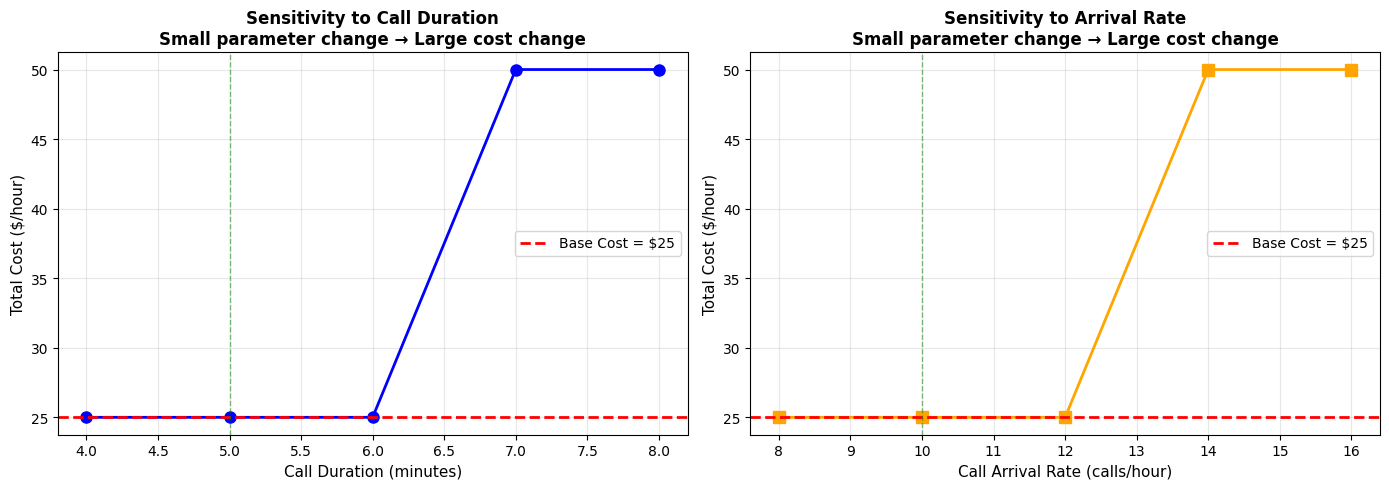


KEY INSIGHT:
  - Both parameters show high sensitivity
  - Small parameter errors cause large cost changes
  - This is why parameter accuracy matters!


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Call duration sensitivity
duration_tests = [t for t in sensitivity_tests if t['Parameter'] == 'Call Duration']
durations = [t['Param Value'] for t in duration_tests]
costs_duration = [t['Cost'] for t in duration_tests]

ax1 = axes[0]
ax1.plot(durations, costs_duration, 'o-', color='blue', linewidth=2, markersize=8)
ax1.axhline(y=total_cost_base, color='red', linestyle='--', linewidth=2, 
            label=f'Base Cost = ${total_cost_base:.0f}')
ax1.axvline(x=avg_call_duration, color='green', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_xlabel('Call Duration (minutes)', fontsize=11)
ax1.set_ylabel('Total Cost ($/hour)', fontsize=11)
ax1.set_title('Sensitivity to Call Duration\nSmall parameter change → Large cost change', 
              fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Arrival rate sensitivity
arrival_tests = [t for t in sensitivity_tests if t['Parameter'] == 'Arrival Rate']
arrivals = [t['Param Value'] for t in arrival_tests]
costs_arrival = [t['Cost'] for t in arrival_tests]

ax2 = axes[1]
ax2.plot(arrivals, costs_arrival, 's-', color='orange', linewidth=2, markersize=8)
ax2.axhline(y=total_cost_base, color='red', linestyle='--', linewidth=2, 
            label=f'Base Cost = ${total_cost_base:.0f}')
ax2.axvline(x=call_arrival_rate, color='green', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('Call Arrival Rate (calls/hour)', fontsize=11)
ax2.set_ylabel('Total Cost ($/hour)', fontsize=11)
ax2.set_title('Sensitivity to Arrival Rate\nSmall parameter change → Large cost change', 
              fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKEY INSIGHT:")
print("  - Both parameters show high sensitivity")
print("  - Small parameter errors cause large cost changes")
print("  - This is why parameter accuracy matters!")


## Step 5: Uncertainty Affects Confidence

Let's see how parameter uncertainty affects our confidence in the recommendation:


PARAMETER UNCERTAINTY:

    Parameter  Base Value          Uncertainty Uncertainty Level
Call Duration         5.0       ±20% (4-6 min)            Medium
 Arrival Rate        10.0 ±20% (8-12 calls/hr)              High
   Agent Cost        25.0   ±0% (from payroll)               Low


CONFIDENCE ASSESSMENT:
  Highest uncertainty: High (Arrival Rate)
  Overall confidence in recommendation: Low
  Reason: You cannot have high confidence when key parameters have high uncertainty


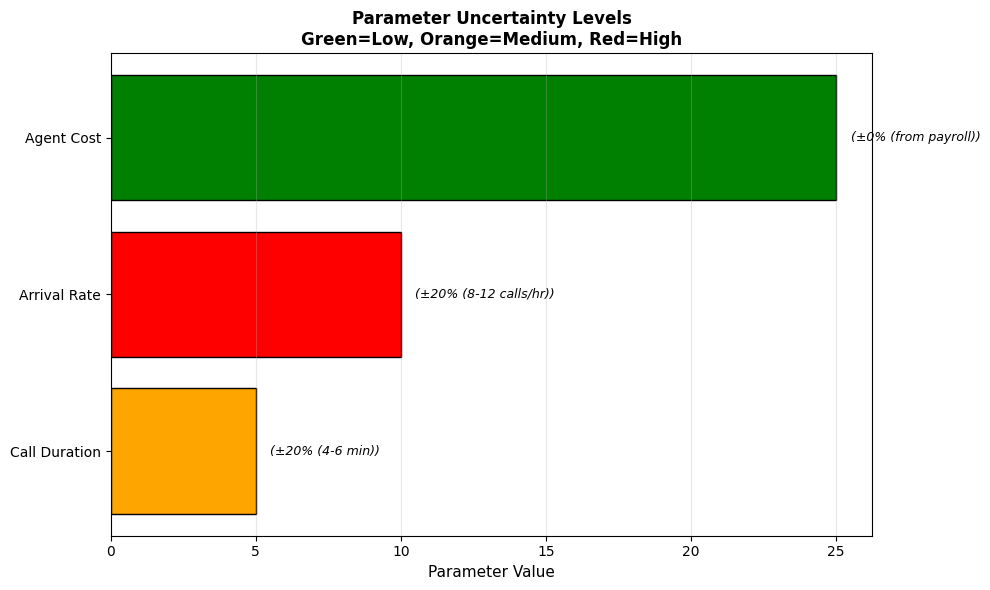



PRACTICAL IMPLICATION:
  - Recommendation: Schedule 1 agents
  - Confidence: Low (due to parameter uncertainty)
  - Action: Test sensitivity, consider ranges, build in buffers


In [5]:
# Parameter uncertainty levels
parameters = pd.DataFrame({
    'Parameter': ['Call Duration', 'Arrival Rate', 'Agent Cost'],
    'Base Value': [avg_call_duration, call_arrival_rate, agent_cost],
    'Uncertainty': ['±20% (4-6 min)', '±20% (8-12 calls/hr)', '±0% (from payroll)'],
    'Uncertainty Level': ['Medium', 'High', 'Low']
})

print("PARAMETER UNCERTAINTY:\n")
print(parameters.to_string(index=False))

# Calculate confidence based on uncertainty
# High uncertainty in key parameters = Low confidence
max_uncertainty = 'High'  # Arrival rate has high uncertainty
if max_uncertainty == 'High':
    confidence = 'Low'
elif max_uncertainty == 'Medium':
    confidence = 'Medium'
else:
    confidence = 'High'

print(f"\n\nCONFIDENCE ASSESSMENT:")
print(f"  Highest uncertainty: {max_uncertainty} (Arrival Rate)")
print(f"  Overall confidence in recommendation: {confidence}")
print(f"  Reason: You cannot have high confidence when key parameters have high uncertainty")

# Visualize uncertainty and confidence
fig, ax = plt.subplots(figsize=(10, 6))

uncertainty_colors = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}
colors = [uncertainty_colors.get(level, 'gray') for level in parameters['Uncertainty Level']]

bars = ax.barh(parameters['Parameter'], parameters['Base Value'], color=colors, edgecolor='black')
ax.set_xlabel('Parameter Value', fontsize=11)
ax.set_title('Parameter Uncertainty Levels\nGreen=Low, Orange=Medium, Red=High', 
             fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add uncertainty labels
for i, (bar, unc) in enumerate(zip(bars, parameters['Uncertainty'])):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
            f"({unc})", va='center', fontsize=9, style='italic')

plt.tight_layout()
plt.show()

print(f"\n\nPRACTICAL IMPLICATION:")
print(f"  - Recommendation: Schedule {agents_needed_base:.0f} agents")
print(f"  - Confidence: {confidence} (due to parameter uncertainty)")
print(f"  - Action: Test sensitivity, consider ranges, build in buffers")


## Summary: Parameter Sensitivity

**Key Takeaways:**

1. **Small parameter errors can cause large recommendation errors**
   - A 5% parameter error might cause a 20% recommendation error
   - Models optimize based on parameters, so errors propagate
   - You cannot assume small errors have small effects

2. **Models can be sensitive to parameters**
   - Some parameters have large effects on recommendations
   - Understanding sensitivity helps identify which parameters matter most
   - Test sensitivity to understand risk

3. **Uncertainty affects confidence**
   - High uncertainty in parameters → Low confidence in recommendations
   - Low uncertainty in parameters → Higher confidence
   - You cannot have high confidence when parameters have high uncertainty

4. **Practical implications**
   - Test sensitivity: What if parameters are wrong?
   - Identify which parameters matter most
   - Build robustness into recommendations
   - Adjust confidence based on parameter uncertainty

**Remember**: Parameters are estimates. Test sensitivity to understand how parameter errors affect recommendations!
